In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

In [12]:
# from google.colab import drive
# drive.mount('/content/drive')

In [13]:
df = pd.read_csv('../../raw_data/mbti_1.csv')
df.head(5)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [14]:
# Create one binary column for each MBTI letter
df['IE'] = df['type'].apply(lambda x: 1 if x[0] == 'I' else 0)
df['NS'] = df['type'].apply(lambda x: 1 if x[1] == 'N' else 0)
df['TF'] = df['type'].apply(lambda x: 1 if x[2] == 'T' else 0)
df['JP'] = df['type'].apply(lambda x: 1 if x[3] == 'J' else 0)

In [15]:
import re

def clean_posts(text):
    # Split the tweets on ||||
    tweets = text.split("|||")
    cleaned = []

    for tweet in tweets:
        # Remove mentions
        tweet = re.sub(r'@\w+', '', tweet)
        # Remove URLs
        tweet = re.sub(r'http\S+', '', tweet)
        # Normalize unicode quotes and dashes (optional)
        tweet = tweet.replace('’', "'").replace('“', '"').replace('”', '"')
        # Keep basic punctuation, remove other non-letter characters
        tweet = re.sub(r'[^a-zA-Z0-9\s.,!?\'"]', '', tweet)
        # Remove extra whitespace
        tweet = re.sub(r'\s+', ' ', tweet).strip()
        # Lowercase
        tweet = tweet.lower()
        # Append only if not empty
        if tweet:
            cleaned.append(tweet)

    # Join tweets with a period and line break for readability
    return ". ".join(cleaned)

In [16]:
df['clean_text'] = df['posts'].apply(clean_posts)

In [17]:
print(df['clean_text'].iloc[1])

'i'm finding the lack of me in these posts very alarming.. sex can be boring if it's in the same position often. for example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. there isn't enough.... giving new meaning to 'game' theory.. hello entp grin that's all it takes. than we converse and they do most of the flirting while i acknowledge their presence and return their words with smooth wordplay and more cheeky grins.. this lack of balance and hand eye coordination.. real iq test i score 127. internet iq tests are funny. i score 140s or higher. now, like the former responses of this thread i will mention that i don't believe in the iq test. before you banish.... you know you're an entp when you vanish from a site for a year and a half, return, and find people are still commenting on your posts and liking your ideasthoughts. you know you're an entp when you.... i over think things sometimes. i go by the old sherlock holmes qu

In [18]:
print(f"balance of the target ie : {df['IE'].value_counts(normalize=True)}")
print(f"balance of the target ns :{df['NS'].value_counts(normalize=True)}")
print(f"balance of the target tf :{df['TF'].value_counts(normalize=True)}")
print(f"balance of the target jp :{df['JP'].value_counts(normalize=True)}")

balance of the target ie : IE
1    0.769568
0    0.230432
Name: proportion, dtype: float64
balance of the target ns :NS
1    0.862017
0    0.137983
Name: proportion, dtype: float64
balance of the target tf :TF
0    0.541095
1    0.458905
Name: proportion, dtype: float64
balance of the target jp :JP
0    0.60415
1    0.39585
Name: proportion, dtype: float64


In [19]:
df['text_length_words'] = df['clean_text'].str.split().apply(len)

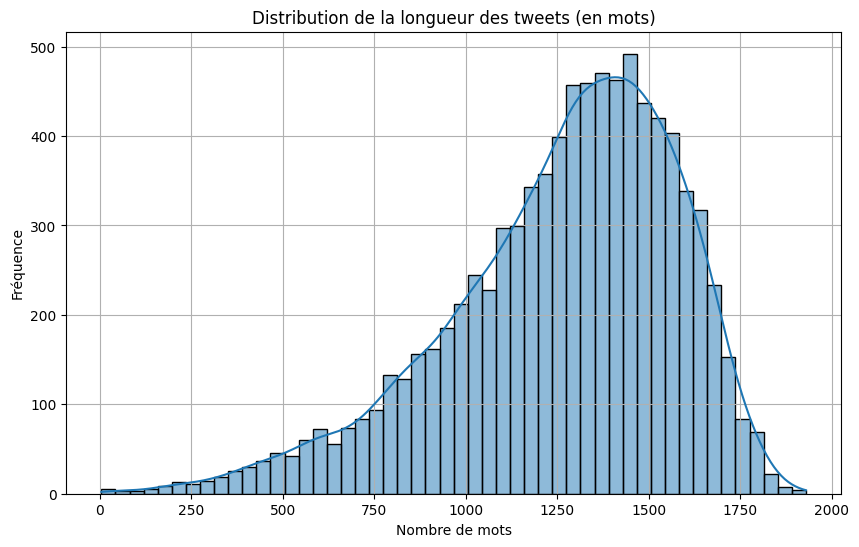

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['text_length_words'], bins=50, kde=True)
plt.title("Distribution de la longueur des tweets (en mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()

In [21]:
df = df[df['clean_text'].apply(lambda x: len(x.split()) < 1700 and len(x.split()) > 1000)].reset_index(drop=True)

In [22]:
df.describe()

,IE,NS,TF,JP,text_length_words
count,6688.000000,6688.000000,6688.000000,6688.000000,6688.000000
mean,0.767793,0.872309,0.452901,0.399821,1364.697069
std,0.422272,0.333771,0.497814,0.489898,181.364192
min,0.000000,0.000000,0.000000,0.000000,1001.000000
25%,1.000000,1.000000,0.000000,0.000000,1224.000000
50%,1.000000,1.000000,0.000000,0.000000,1373.000000
75%,1.000000,1.000000,1.000000,1.000000,1511.000000
max,1.000000,1.000000,1.000000,1.000000,1699.000000


In [23]:
df['clean_text'][0]

"'i'm finding the lack of me in these posts very alarming.. sex can be boring if it's in the same position often. for example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. there isn't enough.... giving new meaning to 'game' theory.. hello entp grin that's all it takes. than we converse and they do most of the flirting while i acknowledge their presence and return their words with smooth wordplay and more cheeky grins.. this lack of balance and hand eye coordination.. real iq test i score 127. internet iq tests are funny. i score 140s or higher. now, like the former responses of this thread i will mention that i don't believe in the iq test. before you banish.... you know you're an entp when you vanish from a site for a year and a half, return, and find people are still commenting on your posts and liking your ideasthoughts. you know you're an entp when you.... i over think things sometimes. i go by the old sherlock holmes q

In [24]:
!pip install xgboost

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [26]:
custom_stopwords = {
    "intj", "intp", "entj", "entp",
    "infj", "infp", "enfj", "enfp",
    "istj", "isfj", "estj", "esfj",
    "istp", "isfp", "estp", "esfp",
    "intjs", "intps", "entjs", "entps",
    "infjs", "infps", "enfjs", "enfps",
    "istjs", "isfjs", "estjs", "esfjs",
    "istps", "isfps", "estps", "esfps",
}

# Fusionner avec les stopwords anglais
combined_stopwords = list(ENGLISH_STOP_WORDS.union(custom_stopwords))

vectorizer = TfidfVectorizer(max_features=20000,
                             ngram_range=(1, 2),
                             stop_words=combined_stopwords)

X = vectorizer.fit_transform(df["clean_text"])

In [27]:
y_tf = df["TF"]
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X, y_tf, test_size=0.2, random_state=42)
model_tf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_tf.fit(X_train_tf, y_train_tf)
y_pred_tf = model_tf.predict(X_test_tf)
print(classification_report(y_test_tf, y_pred_tf))

/home/tanguy/.pyenv/versions/vibe/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:33:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.77      0.79      0.78       740
           1       0.73      0.70      0.71       598

    accuracy                           0.75      1338
   macro avg       0.75      0.75      0.75      1338
weighted avg       0.75      0.75      0.75      1338



In [28]:
# Get feature importances
importances_tf = model_tf.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_tf = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_tf = list(zip(feature_names_tf, importances_tf))

# Sort by importance
word_importances_tf = sorted(word_importances_tf, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_tf[:20]:
    print(f"{word}: {importance:.4f}")

feel: 0.0078
love: 0.0054
beautiful: 0.0049
exciting: 0.0045
4w5: 0.0043
things think: 0.0037
networking: 0.0037
xd: 0.0037
sharing: 0.0037
struggling: 0.0037
bands: 0.0036
4w3: 0.0036
article: 0.0035
arguments: 0.0034
tv: 0.0032
nts: 0.0032
project: 0.0032
result: 0.0032
glad: 0.0032
sports: 0.0031


In [29]:
y_ie = df["IE"]
X_train_ie, X_test_ie, y_train_ie, y_test_ie = train_test_split(X, y_ie, test_size=0.2, random_state=42)
model_ie = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_ie.fit(X_train_ie, y_train_ie)
y_pred_ie = model_ie.predict(X_test_ie)
print(classification_report(y_test_ie, y_pred_ie))

/home/tanguy/.pyenv/versions/vibe/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:34:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.58      0.19      0.28       301
           1       0.80      0.96      0.87      1037

    accuracy                           0.79      1338
   macro avg       0.69      0.57      0.58      1338
weighted avg       0.75      0.79      0.74      1338



In [30]:
# Get feature importances
importances_ie = model_ie.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_ie = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_ie = list(zip(feature_names_ie, importances_ie))

# Sort by importance
word_importances_ie = sorted(word_importances_ie, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_ie[:20]:
    print(f"{word}: {importance:.4f}")

rainbows: 0.0054
guys: 0.0053
7w8: 0.0050
die: 0.0045
dear anonymous: 0.0045
remembered: 0.0043
boo: 0.0042
communicate: 0.0042
manager: 0.0040
trouble: 0.0039
social butterfly: 0.0039
hahaha: 0.0039
ne: 0.0038
extremely: 0.0038
reminds: 0.0037
dancing: 0.0036
angry: 0.0036
just like: 0.0035
nts: 0.0034
convincing: 0.0034


In [31]:
y_ns = df["NS"]
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X, y_ns, test_size=0.2, random_state=42)
model_ns = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_ns.fit(X_train_ns, y_train_ns)
y_pred_ns = model_ns.predict(X_test_ns)
print(classification_report(y_test_ns, y_pred_ns))

/home/tanguy/.pyenv/versions/vibe/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:36:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.55      0.03      0.06       184
           1       0.87      1.00      0.93      1154

    accuracy                           0.86      1338
   macro avg       0.71      0.51      0.49      1338
weighted avg       0.82      0.86      0.81      1338



In [32]:
# Get feature importances
importances_ns = model_ns.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_ns = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_ns = list(zip(feature_names_ns, importances_ns))

# Sort by importance
word_importances_ns = sorted(word_importances_ns, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_ns[:20]:
    print(f"{word}: {importance:.4f}")

inferior ne: 0.0096
snowboarding: 0.0082
se ni: 0.0064
battery: 0.0063
garlic: 0.0062
cars: 0.0061
come conclusion: 0.0061
niss: 0.0055
child: 0.0053
wtf: 0.0053
eventually: 0.0052
job: 0.0051
tini: 0.0051
mechanic: 0.0051
tbh: 0.0051
don like: 0.0049
wants: 0.0048
guessing: 0.0047
makes lot: 0.0043
schedule: 0.0041


In [33]:
# Get feature importances
importances_jp = model_ns.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_jp = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_jp = list(zip(feature_names_jp, importances_jp))

# Sort by importance
word_importances_jp = sorted(word_importances_jp, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_jp[:20]:
    print(f"{word}: {importance:.4f}")

inferior ne: 0.0096
snowboarding: 0.0082
se ni: 0.0064
battery: 0.0063
garlic: 0.0062
cars: 0.0061
come conclusion: 0.0061
niss: 0.0055
child: 0.0053
wtf: 0.0053
eventually: 0.0052
job: 0.0051
tini: 0.0051
mechanic: 0.0051
tbh: 0.0051
don like: 0.0049
wants: 0.0048
guessing: 0.0047
makes lot: 0.0043
schedule: 0.0041


In [34]:
y_jp = df["JP"]
X_train_jp, X_test_jp, y_train_jp, y_test_jp = train_test_split(X, y_jp, test_size=0.2, random_state=42)
model_jp = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_jp.fit(X_train_jp, y_train_jp)
y_pred_jp = model_jp.predict(X_test_jp)
print(classification_report(y_test_jp, y_pred_jp))

/home/tanguy/.pyenv/versions/vibe/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:37:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.66      0.79      0.72       802
           1       0.56      0.40      0.47       536

    accuracy                           0.63      1338
   macro avg       0.61      0.59      0.59      1338
weighted avg       0.62      0.63      0.62      1338



In [35]:
# Get feature importances
importances_jp = model_ns.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_jp = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_jp = list(zip(feature_names_jp, importances_jp))

# Sort by importance
word_importances_jp = sorted(word_importances_jp, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_jp[:20]:
    print(f"{word}: {importance:.4f}")

inferior ne: 0.0096
snowboarding: 0.0082
se ni: 0.0064
battery: 0.0063
garlic: 0.0062
cars: 0.0061
come conclusion: 0.0061
niss: 0.0055
child: 0.0053
wtf: 0.0053
eventually: 0.0052
job: 0.0051
tini: 0.0051
mechanic: 0.0051
tbh: 0.0051
don like: 0.0049
wants: 0.0048
guessing: 0.0047
makes lot: 0.0043
schedule: 0.0041


In [36]:
ie_pred = ['i' if x == 1 else 'e' for x in y_pred_ie]
ns_pred = ['n' if x == 1 else 's' for x in y_pred_ns]
tf_pred = ['t' if x == 1 else 'f' for x in y_pred_tf]
jp_pred = ['j' if x == 1 else 'p' for x in y_pred_jp]

y_test_ie_l = ['i' if x == 1 else 'e' for x in y_test_ie]
y_test_ns_l = ['n' if x == 1 else 's' for x in y_test_ns]
y_test_tf_l = ['t' if x == 1 else 'f' for x in y_test_tf]
y_test_jp_l = ['j' if x == 1 else 'p' for x in y_test_jp]

In [37]:
# Create DataFrame
df_pred = pd.DataFrame({
    'IE': ie_pred,
    'NS': ns_pred,
    'TF': tf_pred,
    'JP': jp_pred,
    'IE_test': y_test_ie_l,
    'NS_test': y_test_ns_l,
    'TF_test': y_test_tf_l,
    'JP_test': y_test_jp_l
})

df_pred['MBTI'] = df_pred['IE'] + df_pred['NS'] + df_pred['TF'] + df_pred['JP']
df_pred['MBTI_test'] = df_pred['IE_test'] + df_pred['NS_test'] + df_pred['TF_test'] + df_pred['JP_test']

In [38]:
df_pred

,IE,NS,TF,JP,IE_test,NS_test,TF_test,JP_test,MBTI,MBTI_test
0,i,n,f,p,i,n,f,p,infp,infp
1,e,n,f,p,e,n,f,p,enfp,enfp
2,i,n,t,p,i,n,f,j,intp,infj
3,i,n,t,p,i,n,t,p,intp,intp
4,i,n,t,j,e,n,t,p,intj,entp
...,...,...,...,...,...,...,...,...,...,...
1333,i,n,f,p,i,n,t,p,infp,intp
1334,e,n,f,j,i,n,f,j,enfj,infj
1335,i,n,t,p,i,n,t,p,intp,intp
1336,i,n,f,p,i,n,f,p,infp,infp


In [39]:
accuracy = (df_pred['MBTI'] == df_pred['MBTI_test']).mean() * 100

print(f"Pourcentage de MBTI correctement prédits : {accuracy:.2f}%")

Pourcentage de MBTI correctement prédits : 31.84%


In [40]:
accuracy_ie = (df_pred['IE'] == df_pred['IE_test']).mean() * 100
accuracy_ns = (df_pred['NS'] == df_pred['NS_test']).mean() * 100
accuracy_tf = (df_pred['TF'] == df_pred['TF_test']).mean() * 100
accuracy_jp = (df_pred['JP'] == df_pred['JP_test']).mean() * 100


print(f"Pourcentage de IE correctement prédits : {accuracy_ie:.2f}%")
print(f"Pourcentage de NS correctement prédits : {accuracy_ns:.2f}%")
print(f"Pourcentage de TF correctement prédits : {accuracy_tf:.2f}%")
print(f"Pourcentage de JP correctement prédits : {accuracy_jp:.2f}%")

Pourcentage de IE correctement prédits : 78.62%
Pourcentage de NS correctement prédits : 86.32%
Pourcentage de TF correctement prédits : 75.04%
Pourcentage de JP correctement prédits : 63.30%


In [41]:
df_last_model = pd.DataFrame({
        'IE': y_pred_ie,
        'NS': y_pred_ns,
        'TF': y_pred_tf,
        'JP': y_pred_jp,
        'IE_test': y_test_ie,
        'NS_test': y_test_ns,
        'TF_test': y_test_tf,
        'JP_test': y_test_jp
    })

In [42]:
df_last_model

,IE,NS,TF,JP,IE_test,NS_test,TF_test,JP_test
247,1,1,0,0,1,1,0,0
2464,0,1,0,0,0,1,0,0
6081,1,1,1,0,1,1,0,1
5944,1,1,1,0,1,1,1,0
6566,1,1,1,1,0,1,1,0
...,...,...,...,...,...,...,...,...
5922,1,1,0,0,1,1,1,0
4864,0,1,0,1,1,1,0,1
1760,1,1,1,0,1,1,1,0
807,1,1,0,0,1,1,0,0


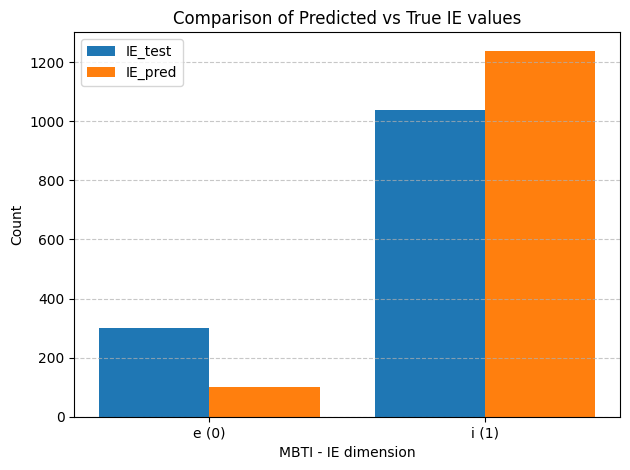

In [43]:
# Count the values of 0 and 1 for prediction and true labels
ie_pred_counts = df_last_model['IE'].value_counts().sort_index()
ie_test_counts = df_last_model['IE_test'].value_counts().sort_index()

# Define labels
labels = ['e (0)', 'i (1)']
x = range(len(labels))

# Bar plot side by side
plt.bar([i - 0.2 for i in x], [ie_test_counts.get(i, 0) for i in range(2)], width=0.4, label='IE_test')
plt.bar([i + 0.2 for i in x], [ie_pred_counts.get(i, 0) for i in range(2)], width=0.4, label='IE_pred')

plt.xticks(x, labels)
plt.xlabel('MBTI - IE dimension')
plt.ylabel('Count')
plt.title('Comparison of Predicted vs True IE values')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

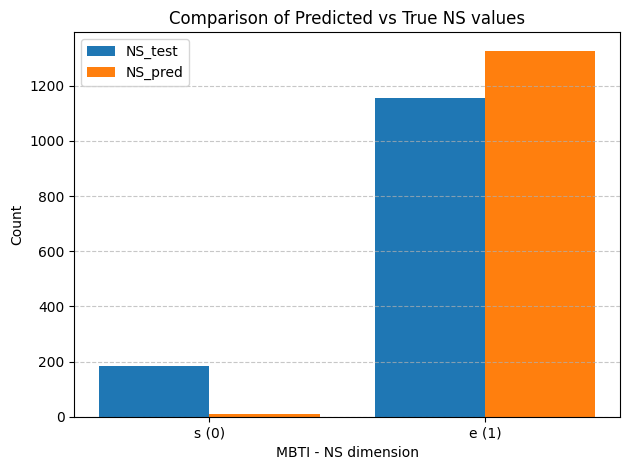

In [44]:
# Count the values of 0 and 1 for prediction and true labels
ns_pred_counts = df_last_model['NS'].value_counts().sort_index()
ns_test_counts = df_last_model['NS_test'].value_counts().sort_index()

# Define labels
labels = ['s (0)', 'e (1)']
x = range(len(labels))

# Bar plot side by side
plt.bar([i - 0.2 for i in x], [ns_test_counts.get(i, 0) for i in range(2)], width=0.4, label='NS_test')
plt.bar([i + 0.2 for i in x], [ns_pred_counts.get(i, 0) for i in range(2)], width=0.4, label='NS_pred')

plt.xticks(x, labels)
plt.xlabel('MBTI - NS dimension')
plt.ylabel('Count')
plt.title('Comparison of Predicted vs True NS values')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

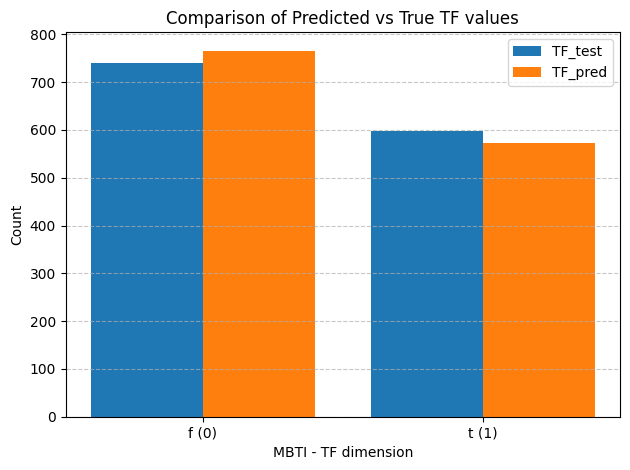

In [45]:
# Count the values of 0 and 1 for prediction and true labels
tf_pred_counts = df_last_model['TF'].value_counts().sort_index()
tf_test_counts = df_last_model['TF_test'].value_counts().sort_index()

# Define labels
labels = ['f (0)', 't (1)']
x = range(len(labels))

# Bar plot side by side
plt.bar([i - 0.2 for i in x], [tf_test_counts.get(i, 0) for i in range(2)], width=0.4, label='TF_test')
plt.bar([i + 0.2 for i in x], [tf_pred_counts.get(i, 0) for i in range(2)], width=0.4, label='TF_pred')

plt.xticks(x, labels)
plt.xlabel('MBTI - TF dimension')
plt.ylabel('Count')
plt.title('Comparison of Predicted vs True TF values')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

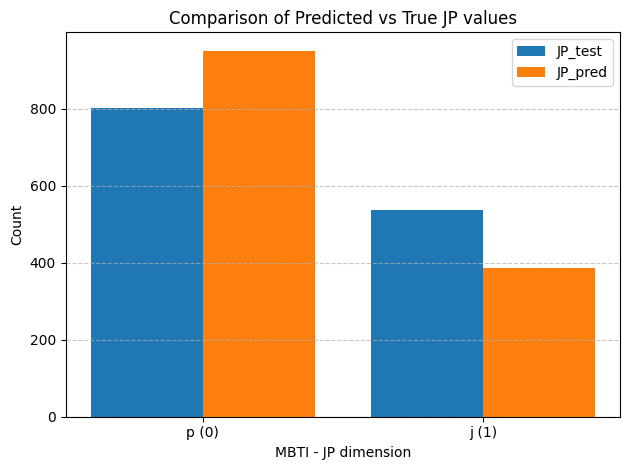

In [46]:
# Count the values of 0 and 1 for prediction and true labels
jp_pred_counts = df_last_model['JP'].value_counts().sort_index()
jp_test_counts = df_last_model['JP_test'].value_counts().sort_index()

# Define labels
labels = ['p (0)', 'j (1)']
x = range(len(labels))

# Bar plot side by side
plt.bar([i - 0.2 for i in x], [jp_test_counts.get(i, 0) for i in range(2)], width=0.4, label='JP_test')
plt.bar([i + 0.2 for i in x], [jp_pred_counts.get(i, 0) for i in range(2)], width=0.4, label='JP_pred')

plt.xticks(x, labels)
plt.xlabel('MBTI - JP dimension')
plt.ylabel('Count')
plt.title('Comparison of Predicted vs True JP values')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()